![Credit card being held in hand](credit_card.jpg)

Commercial banks receive _a lot_ of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this workbook, you will build an automatic credit card approval predictor using machine learning techniques, just like real banks do.

### The Data

The data is a small subset of the Credit Card Approval dataset from the UCI Machine Learning Repository showing the credit card applications a bank receives. This dataset has been loaded as a `pandas` DataFrame called `cc_apps`. The last column in the dataset is the target value.

In [135]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# Load the dataset
cc_apps = pd.read_csv("cc_approvals.data", header=None) 
cc_apps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,g,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,g,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,g,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,g,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,s,0,+


## Data Validation

In [136]:
# Chekcing the dtypes of the features

cc_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 non-null    object 
 12  12      690 non-null    int64  
 13  13      690 non-null    object 
dtypes: float64(2), int64(2), object(10)
memory usage: 75.6+ KB


In [137]:
# Data Type Constraints

cc_apps.iloc[:,1].value_counts()  # checking the entries of column 1
cc_apps.iloc[:,1]=cc_apps.iloc[:,1].replace({'?':np.nan}).astype('float')
assert cc_apps.iloc[:,1].dtype=='float'

# Data Range Constraints

non_nummericals= cc_apps.select_dtypes('object')

for column in non_nummericals.columns:
    display(cc_apps.iloc[:,column].value_counts())
    
# as we can see, missing values are in form of '?'. So we first address this problem.

cc_apps=cc_apps.applymap(lambda x:np.nan if x=='?' else x)

#Sanity check

for column in non_nummericals.columns:
    display(cc_apps.iloc[:,column].value_counts())

# Everything is fine now

b    468
a    210
?     12
Name: 0, dtype: int64

u    519
y    163
?      6
l      2
Name: 3, dtype: int64

g     519
p     163
?       6
gg      2
Name: 4, dtype: int64

c     137
q      78
w      64
i      59
aa     54
ff     53
k      51
cc     41
m      38
x      38
d      30
e      25
j      10
?       9
r       3
Name: 5, dtype: int64

v     399
h     138
bb     59
ff     57
?       9
j       8
z       8
dd      6
n       4
o       2
Name: 6, dtype: int64

t    361
f    329
Name: 8, dtype: int64

f    395
t    295
Name: 9, dtype: int64

g    625
s     57
p      8
Name: 11, dtype: int64

-    383
+    307
Name: 13, dtype: int64

b    468
a    210
Name: 0, dtype: int64

u    519
y    163
l      2
Name: 3, dtype: int64

g     519
p     163
gg      2
Name: 4, dtype: int64

c     137
q      78
w      64
i      59
aa     54
ff     53
k      51
cc     41
m      38
x      38
d      30
e      25
j      10
r       3
Name: 5, dtype: int64

v     399
h     138
bb     59
ff     57
j       8
z       8
dd      6
n       4
o       2
Name: 6, dtype: int64

t    361
f    329
Name: 8, dtype: int64

f    395
t    295
Name: 9, dtype: int64

g    625
s     57
p      8
Name: 11, dtype: int64

-    383
+    307
Name: 13, dtype: int64

In [138]:
cc_apps.iloc[:,13].unique()

array(['+', '-'], dtype=object)

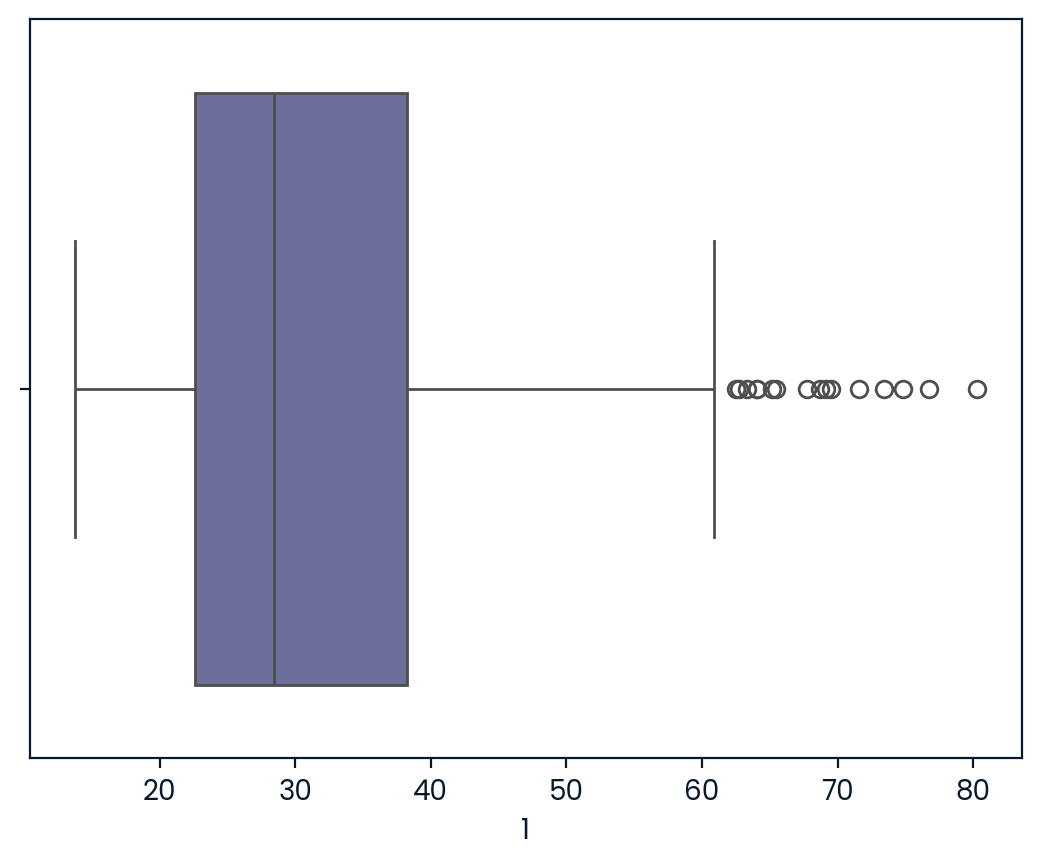

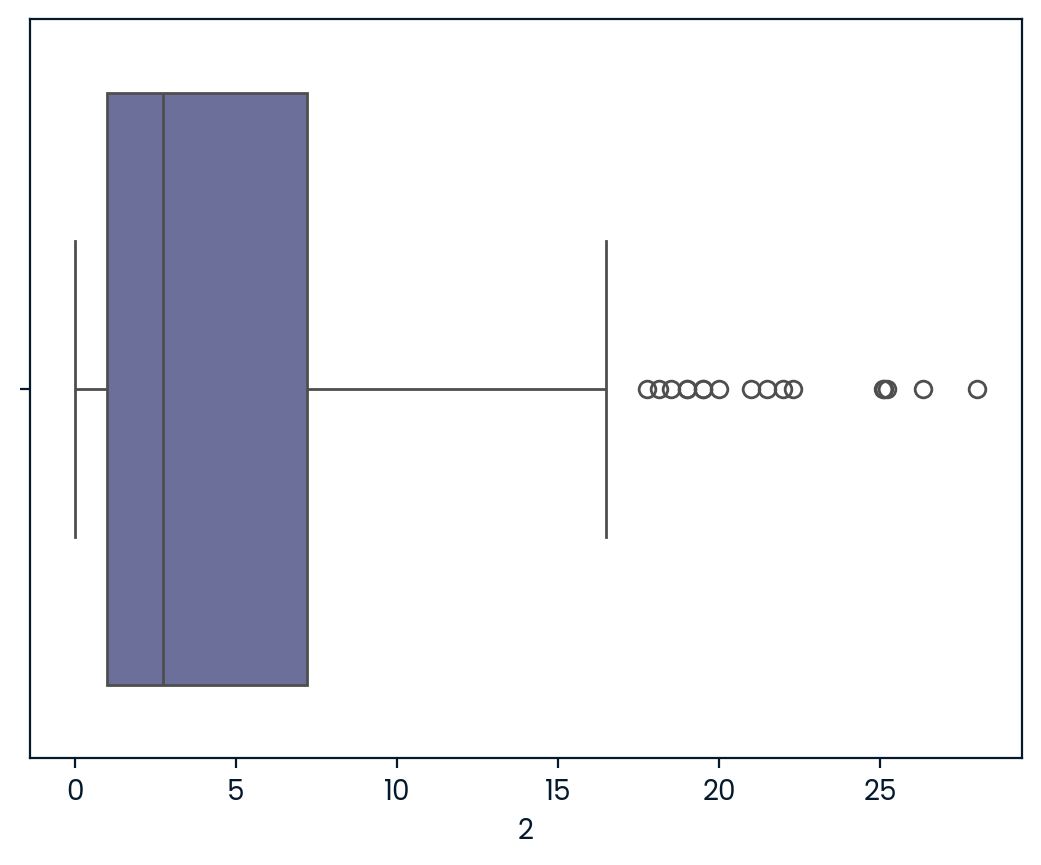

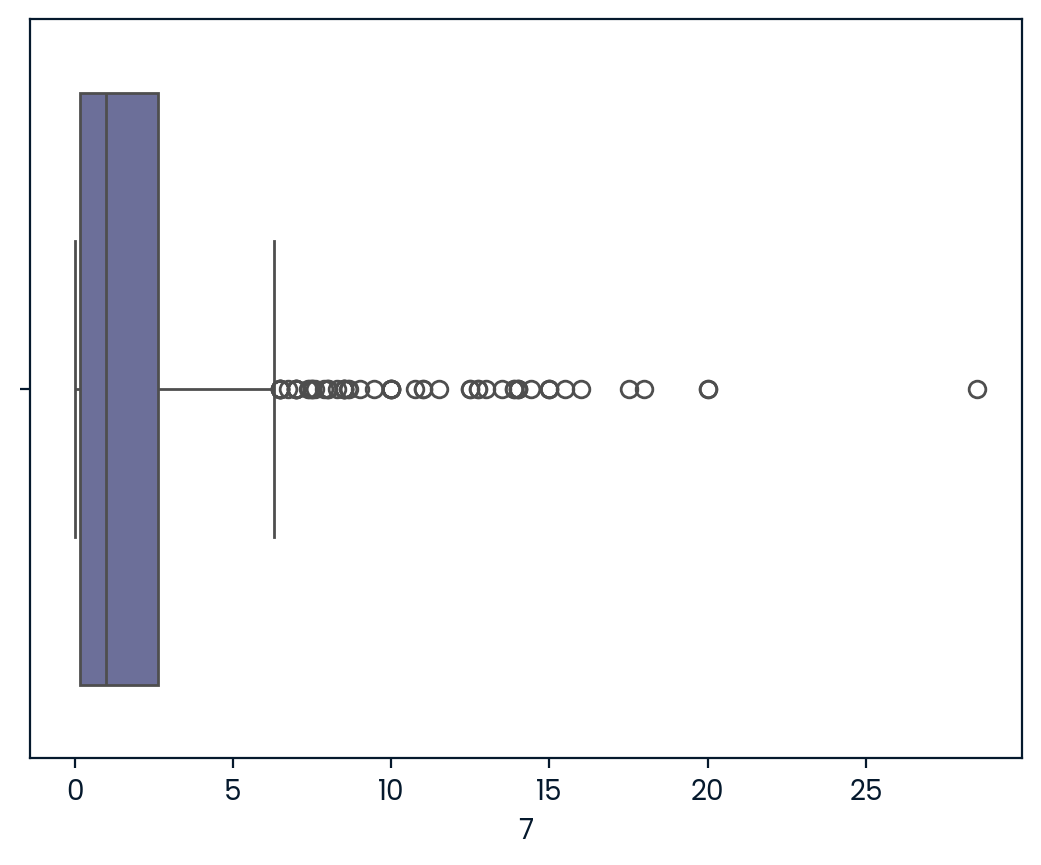

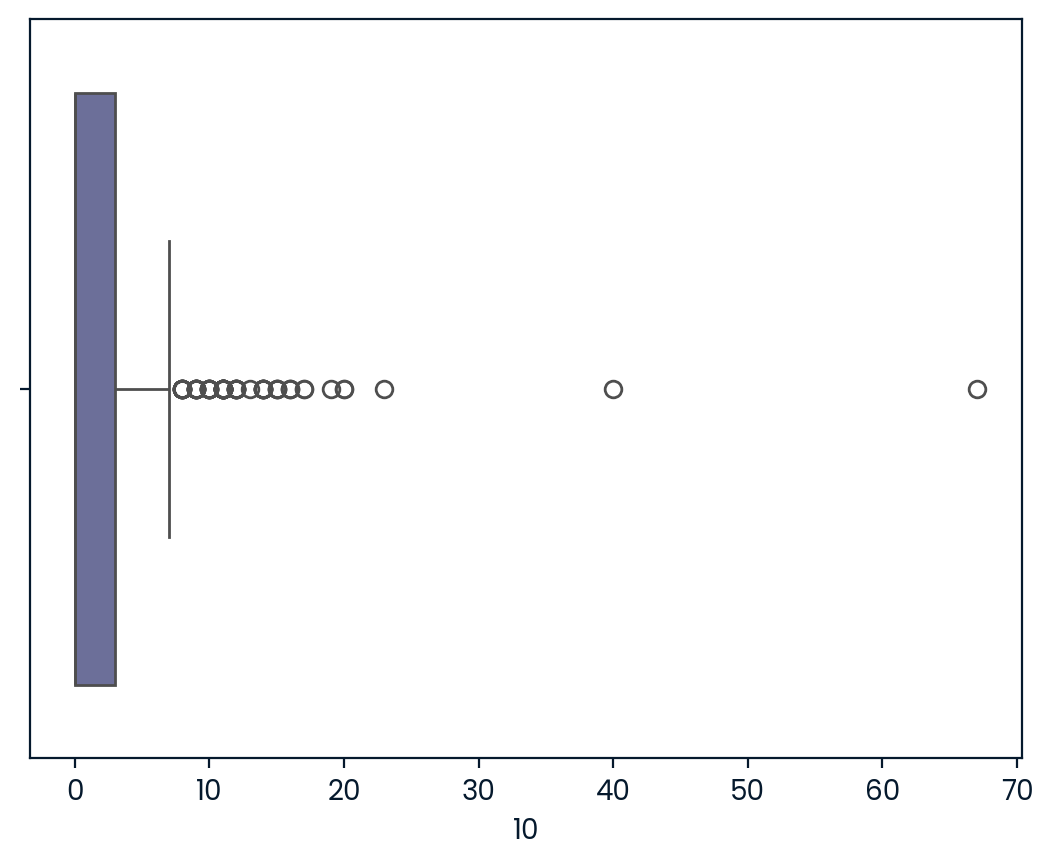

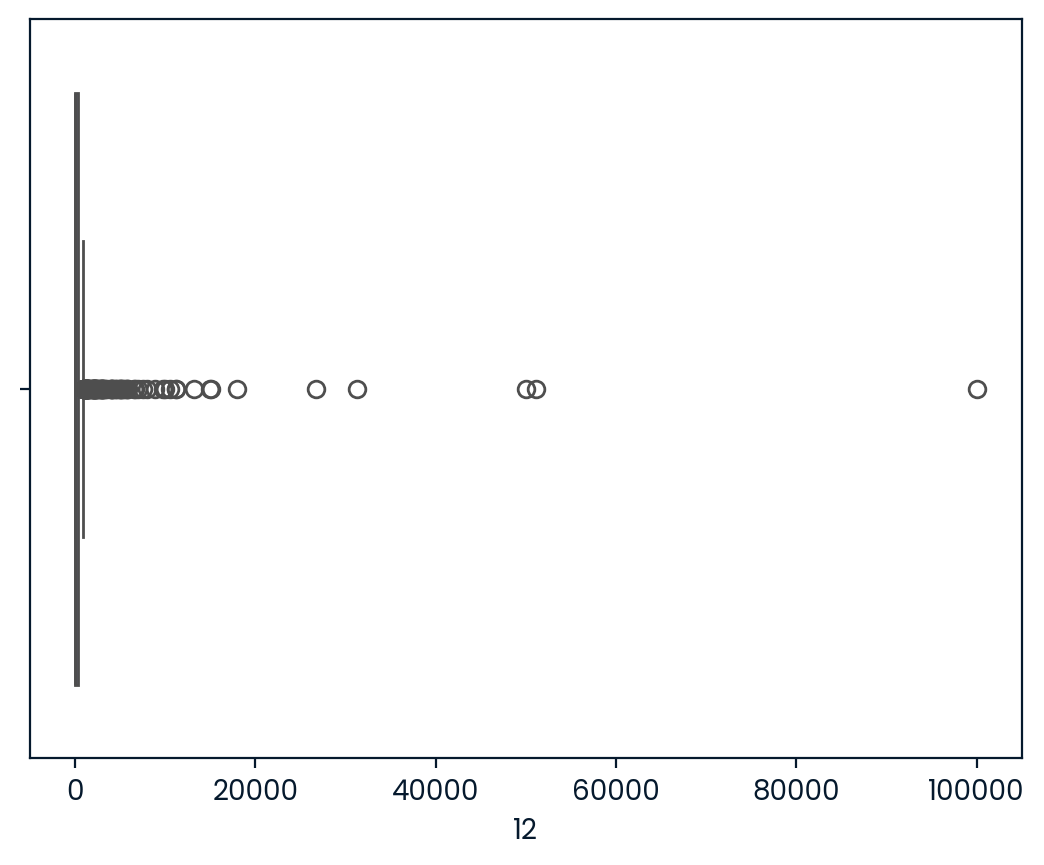

In [139]:
# Checking for outliers in nummerical columns

nummerical_columns= cc_apps.select_dtypes(include=['int','float'])

for column in nummerical_columns.columns:
    sns.boxplot(x=column,data=cc_apps)
    plt.show()

In [140]:
# As can be seen the data in nummerical column sare highly skewd. These outliers will be addressed using data sclaing 

In [141]:
# Checking Duplicates

duplicates=cc_apps.duplicated()
print(cc_apps[duplicates])  # there are no duplicated values


Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Index: []


In [142]:
# Deaking with missing values

cc_apps.dropna(inplace=True) # removing missing values since there are less than 5% of our dataset
cc_apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 659 entries, 0 to 689
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       659 non-null    object 
 1   1       659 non-null    float64
 2   2       659 non-null    float64
 3   3       659 non-null    object 
 4   4       659 non-null    object 
 5   5       659 non-null    object 
 6   6       659 non-null    object 
 7   7       659 non-null    float64
 8   8       659 non-null    object 
 9   9       659 non-null    object 
 10  10      659 non-null    int64  
 11  11      659 non-null    object 
 12  12      659 non-null    int64  
 13  13      659 non-null    object 
dtypes: float64(3), int64(2), object(9)
memory usage: 77.2+ KB


In [143]:

# Step 1: Replace '+' with True and others with False in column 13
cc_apps.iloc[:, 13] = np.where(cc_apps.iloc[:, 13] == "+", True, False)


# Step 2: Encode categorical features (if any)
transformed_df = pd.get_dummies(cc_apps)

transformed_df.columns = transformed_df.columns.astype(str)

# Step 3: Drop a specific column (here, the 6th column by index)
ind_var = transformed_df.drop(transformed_df.columns[5], axis=1)


# Step 4: Scale the independent variables
scaler = StandardScaler()

# Ensure only the columns in ind_var are scaled and assign back the scaled values
transformed_df[ind_var.columns] = scaler.fit_transform(ind_var)

# Step 5: (Optional) Copy transformed_df into scaled_df if you want a separate scaled copy
scaled_df = transformed_df.copy()

# Output scaled DataFrame
scaled_df


,1,2,7,10,12,13,0_a,0_b,3_l,3_u,3_y,4_g,4_gg,4_p,5_aa,5_c,5_cc,5_d,5_e,5_ff,5_i,5_j,5_k,5_m,5_q,5_r,5_w,5_x,6_bb,6_dd,6_ff,6_h,6_j,6_n,6_o,6_v,6_z,8_f,8_t,9_f,9_t,11_g,11_p,11_s
0,-0.054040,-0.967186,-0.296112,-0.303012,-0.196586,True,-0.671969,0.671969,-0.055174,0.559240,-0.554563,0.559240,-0.055174,-0.554563,-0.292690,-0.505211,-0.254205,-0.206692,-0.194410,-0.289623,-0.304744,-0.12413,-0.283422,-0.247369,-0.361054,-0.067625,3.075763,-0.240385,-0.301761,-0.095856,-0.301761,-0.512301,-0.110855,-0.078146,-0.055174,0.846254,-0.110855,-0.933895,0.933895,-1.128013,1.128013,0.301761,-0.055174,-0.295734
1,2.304656,-0.078120,0.233474,0.707540,-0.091342,True,1.488165,-1.488165,-0.055174,0.559240,-0.554563,0.559240,-0.055174,-0.554563,-0.292690,-0.505211,-0.254205,-0.206692,-0.194410,-0.289623,-0.304744,-0.12413,-0.283422,-0.247369,2.769667,-0.067625,-0.325123,-0.240385,-0.301761,-0.095856,-0.301761,1.951978,-0.110855,-0.078146,-0.055174,-1.181678,-0.110855,-0.933895,0.933895,-1.128013,1.128013,0.301761,-0.055174,-0.295734
2,-0.590339,-0.867515,-0.222147,-0.505122,-0.041727,True,1.488165,-1.488165,-0.055174,0.559240,-0.554563,0.559240,-0.055174,-0.554563,-0.292690,-0.505211,-0.254205,-0.206692,-0.194410,-0.289623,-0.304744,-0.12413,-0.283422,-0.247369,2.769667,-0.067625,-0.325123,-0.240385,-0.301761,-0.095856,-0.301761,1.951978,-0.110855,-0.078146,-0.055174,-1.181678,-0.110855,-0.933895,0.933895,0.886514,-0.886514,0.301761,-0.055174,-0.295734
3,-0.308210,-0.660199,0.443533,0.505429,-0.196023,True,-0.671969,0.671969,-0.055174,0.559240,-0.554563,0.559240,-0.055174,-0.554563,-0.292690,-0.505211,-0.254205,-0.206692,-0.194410,-0.289623,-0.304744,-0.12413,-0.283422,-0.247369,-0.361054,-0.067625,3.075763,-0.240385,-0.301761,-0.095856,-0.301761,-0.512301,-0.110855,-0.078146,-0.055174,0.846254,-0.110855,-0.933895,0.933895,-1.128013,1.128013,0.301761,-0.055174,-0.295734
4,-0.957191,0.154114,-0.160017,-0.505122,-0.196586,True,-0.671969,0.671969,-0.055174,0.559240,-0.554563,0.559240,-0.055174,-0.554563,-0.292690,-0.505211,-0.254205,-0.206692,-0.194410,-0.289623,-0.304744,-0.12413,-0.283422,-0.247369,-0.361054,-0.067625,3.075763,-0.240385,-0.301761,-0.095856,-0.301761,-0.512301,-0.110855,-0.078146,-0.055174,0.846254,-0.110855,-0.933895,0.933895,0.886514,-0.886514,-3.313883,-0.055174,3.381414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,-0.880092,1.043180,-0.296112,-0.505122,-0.196586,False,-0.671969,0.671969,-0.055174,-1.788142,1.803223,-1.788142,-0.055174,1.803223,-0.292690,-0.505211,-0.254205,-0.206692,5.143766,-0.289623,-0.304744,-0.12413,-0.283422,-0.247369,-0.361054,-0.067625,-0.325123,-0.240385,-0.301761,-0.095856,-0.301761,1.951978,-0.110855,-0.078146,-0.055174,-1.181678,-0.110855,1.070785,-1.070785,0.886514,-0.886514,0.301761,-0.055174,-0.295734
686,-0.745382,-0.817680,-0.074218,-0.100902,-0.122539,False,1.488165,-1.488165,-0.055174,0.559240,-0.554563,0.559240,-0.055174,-0.554563,-0.292690,1.979371,-0.254205,-0.206692,-0.194410,-0.289623,-0.304744,-0.12413,-0.283422,-0.247369,-0.361054,-0.067625,-0.325123,-0.240385,-0.301761,-0.095856,-0.301761,-0.512301,-0.110855,-0.078146,-0.055174,0.846254,-0.110855,1.070785,-1.070785,-1.128013,1.128013,0.301761,-0.055174,-0.295734
687,-0.526796,1.723934,-0.074218,-0.303012,-0.196398,False,1.488165,-1.488165,-0.055174,-1.788142,1.803223,-1.788142,-0.055174,1.803223,-0.292690,-0.505211,-0.254205,-0.206692,-0.194410,3.452762,-0.304744,-0.12413,-0.283422,-0.247369,-0.361054,-0.067625,-0.325123,-0.240385,-0.301761,-0.095856,3.313883,-0.512301,-0.110855,-0.078146,-0.055174,-1.181678,-0.110855,1.070785,-1.070785,-1.128013,1.128013,0.301761,-0.055174,-0.295734
688,-1.147818,-0.926321,-0.654100,-0.505122,-0.055634,False,-0.671969,0.671969,-0.055174,0.559240,-0.554563,0.559240,-0.055174,-0.554563,3.416588,-0.505211,-0.254205,-0.206692,-0.194410,-0.289623,-0.304744,-0.12413,-0

In [144]:

# Step 2: Encode categorical features (if any)
transformed_df = pd.get_dummies(cc_apps)

transformed_df.columns = transformed_df.columns.astype(str)

# Step 3: Drop a specific column (here, the 6th column by index)
ind_var = transformed_df.drop(transformed_df.columns[5], axis=1)


# Step 4: Scale the independent variables
scaler = StandardScaler()

# Ensure only the columns in ind_var are scaled and assign back the scaled values
transformed_df[ind_var.columns] = scaler.fit_transform(ind_var)

# Step 5: (Optional) Copy transformed_df into scaled_df if you want a separate scaled copy
scaled_df = transformed_df.copy()

# Output scaled DataFrame
scaled_df


,1,2,7,10,12,13,0_a,0_b,3_l,3_u,3_y,4_g,4_gg,4_p,5_aa,5_c,5_cc,5_d,5_e,5_ff,5_i,5_j,5_k,5_m,5_q,5_r,5_w,5_x,6_bb,6_dd,6_ff,6_h,6_j,6_n,6_o,6_v,6_z,8_f,8_t,9_f,9_t,11_g,11_p,11_s
0,-0.054040,-0.967186,-0.296112,-0.303012,-0.196586,True,-0.671969,0.671969,-0.055174,0.559240,-0.554563,0.559240,-0.055174,-0.554563,-0.292690,-0.505211,-0.254205,-0.206692,-0.194410,-0.289623,-0.304744,-0.12413,-0.283422,-0.247369,-0.361054,-0.067625,3.075763,-0.240385,-0.301761,-0.095856,-0.301761,-0.512301,-0.110855,-0.078146,-0.055174,0.846254,-0.110855,-0.933895,0.933895,-1.128013,1.128013,0.301761,-0.055174,-0.295734
1,2.304656,-0.078120,0.233474,0.707540,-0.091342,True,1.488165,-1.488165,-0.055174,0.559240,-0.554563,0.559240,-0.055174,-0.554563,-0.292690,-0.505211,-0.254205,-0.206692,-0.194410,-0.289623,-0.304744,-0.12413,-0.283422,-0.247369,2.769667,-0.067625,-0.325123,-0.240385,-0.301761,-0.095856,-0.301761,1.951978,-0.110855,-0.078146,-0.055174,-1.181678,-0.110855,-0.933895,0.933895,-1.128013,1.128013,0.301761,-0.055174,-0.295734
2,-0.590339,-0.867515,-0.222147,-0.505122,-0.041727,True,1.488165,-1.488165,-0.055174,0.559240,-0.554563,0.559240,-0.055174,-0.554563,-0.292690,-0.505211,-0.254205,-0.206692,-0.194410,-0.289623,-0.304744,-0.12413,-0.283422,-0.247369,2.769667,-0.067625,-0.325123,-0.240385,-0.301761,-0.095856,-0.301761,1.951978,-0.110855,-0.078146,-0.055174,-1.181678,-0.110855,-0.933895,0.933895,0.886514,-0.886514,0.301761,-0.055174,-0.295734
3,-0.308210,-0.660199,0.443533,0.505429,-0.196023,True,-0.671969,0.671969,-0.055174,0.559240,-0.554563,0.559240,-0.055174,-0.554563,-0.292690,-0.505211,-0.254205,-0.206692,-0.194410,-0.289623,-0.304744,-0.12413,-0.283422,-0.247369,-0.361054,-0.067625,3.075763,-0.240385,-0.301761,-0.095856,-0.301761,-0.512301,-0.110855,-0.078146,-0.055174,0.846254,-0.110855,-0.933895,0.933895,-1.128013,1.128013,0.301761,-0.055174,-0.295734
4,-0.957191,0.154114,-0.160017,-0.505122,-0.196586,True,-0.671969,0.671969,-0.055174,0.559240,-0.554563,0.559240,-0.055174,-0.554563,-0.292690,-0.505211,-0.254205,-0.206692,-0.194410,-0.289623,-0.304744,-0.12413,-0.283422,-0.247369,-0.361054,-0.067625,3.075763,-0.240385,-0.301761,-0.095856,-0.301761,-0.512301,-0.110855,-0.078146,-0.055174,0.846254,-0.110855,-0.933895,0.933895,0.886514,-0.886514,-3.313883,-0.055174,3.381414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,-0.880092,1.043180,-0.296112,-0.505122,-0.196586,False,-0.671969,0.671969,-0.055174,-1.788142,1.803223,-1.788142,-0.055174,1.803223,-0.292690,-0.505211,-0.254205,-0.206692,5.143766,-0.289623,-0.304744,-0.12413,-0.283422,-0.247369,-0.361054,-0.067625,-0.325123,-0.240385,-0.301761,-0.095856,-0.301761,1.951978,-0.110855,-0.078146,-0.055174,-1.181678,-0.110855,1.070785,-1.070785,0.886514,-0.886514,0.301761,-0.055174,-0.295734
686,-0.745382,-0.817680,-0.074218,-0.100902,-0.122539,False,1.488165,-1.488165,-0.055174,0.559240,-0.554563,0.559240,-0.055174,-0.554563,-0.292690,1.979371,-0.254205,-0.206692,-0.194410,-0.289623,-0.304744,-0.12413,-0.283422,-0.247369,-0.361054,-0.067625,-0.325123,-0.240385,-0.301761,-0.095856,-0.301761,-0.512301,-0.110855,-0.078146,-0.055174,0.846254,-0.110855,1.070785,-1.070785,-1.128013,1.128013,0.301761,-0.055174,-0.295734
687,-0.526796,1.723934,-0.074218,-0.303012,-0.196398,False,1.488165,-1.488165,-0.055174,-1.788142,1.803223,-1.788142,-0.055174,1.803223,-0.292690,-0.505211,-0.254205,-0.206692,-0.194410,3.452762,-0.304744,-0.12413,-0.283422,-0.247369,-0.361054,-0.067625,-0.325123,-0.240385,-0.301761,-0.095856,3.313883,-0.512301,-0.110855,-0.078146,-0.055174,-1.181678,-0.110855,1.070785,-1.070785,-1.128013,1.128013,0.301761,-0.055174,-0.295734
688,-1.147818,-0.926321,-0.654100,-0.505122,-0.055634,False,-0.671969,0.671969,-0.055174,0.559240,-0.554563,0.559240,-0.055174,-0.554563,3.416588,-0.505211,-0.254205,-0.206692,-0.194410,-0.289623,-0.304744,-0.12413,-0

In [145]:
# Applying ML to scaled_df
from sklearn.model_selection import cross_val_score, KFold

df_transformed=scaled_df.copy()

X = df_transformed.drop(["13"], axis=1).values  

y = df_transformed['13'].values  #Extracting the target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
        'max_iter': [100, 200, 500, 1000]
}

lr=LogisticRegression()
kf = KFold(n_splits=6, shuffle=True)

# Perform RandomizedSearchCV
lr_cv = GridSearchCV(lr, param_grid, cv=kf, n_jobs=-1)

lr_cv.fit(X_train, y_train)

print(lr_cv.best_params_, lr_cv.best_score_)

{'C': 0.01, 'max_iter': 100, 'solver': 'liblinear'} 0.8652908394287705


In [146]:
best_score=0.86